In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
def EMA(X,n) :
  return X.ewm(span=n,adjust = False).mean()

In [4]:
# Momentum Indicator
def MACD(X) :
  MACDLine = EMA(X['Close'],12)-EMA(X['Close'],26)
  SignalLine = EMA(MACDLine,9)
  return MACDLine,SignalLine

In [5]:
#Volume Indicator
def VolumeRSI(X,n) :
  delta = X['Volume'].diff()
  up = delta.apply(lambda x: x if x > 0 else 0)
  down = delta.apply(lambda x: -x if x < 0 else 0)

  avgup = up.ewm(span = 2*n-1,adjust = False).mean()
  avgdown = down.ewm(span = 2*n-1,adjust = False).mean()
  RS = avgup/avgdown
  return 100-100/(1+RS)

In [6]:
#Volatility Indicator
def AverageTrueRange(X,n) :
  prev = X['Close'].shift(1)
  a = X['High']-X['Low']
  b = (X['High']-prev).abs()
  c = (X['Low']-prev).abs()

  final = pd.concat([a, b, c], axis=1).max(axis=1)
  return final.ewm(span = 2*n-1,adjust = False).mean()

/tmp/ipython-input-2296127831.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Sharpe ratio:       0.3317248980222744
Sortino ratio:      0.15683402528459164
Net Profit:         0.0
Total Trades:       9
Winning Trades:     0
Losing Trades:      9


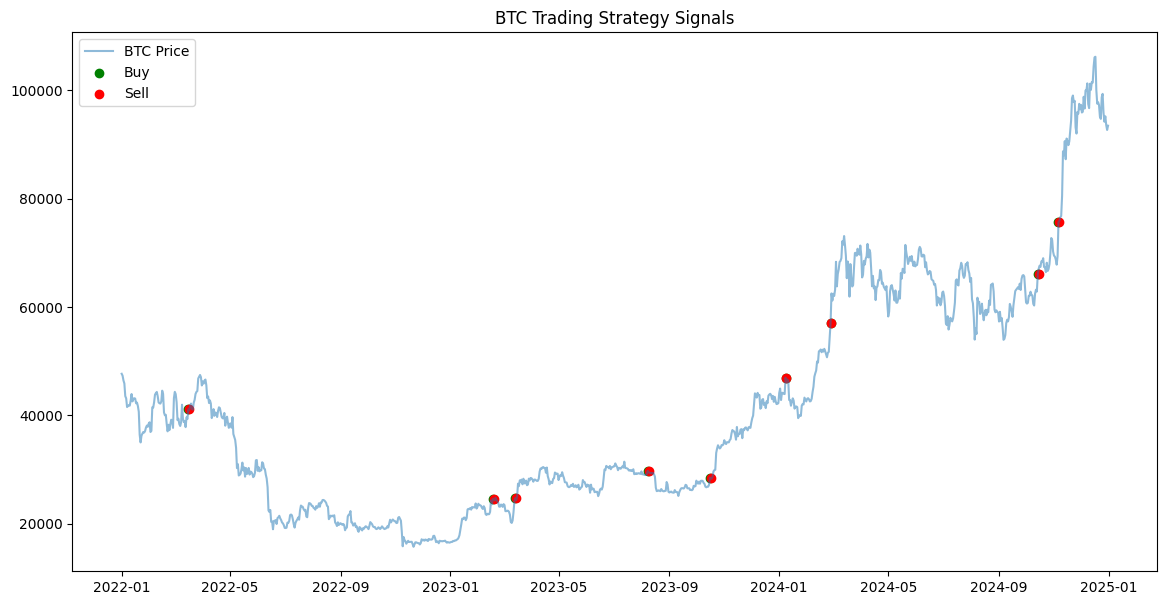


Total Trades: 9
END


In [27]:
# Solution of 2.2
df = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01", interval="1d")

# Copypasted this line to delete extra header in downloaded version from yfinance
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

#Calling all three functions to get indicator values

df['MACDLine'], df['SignalLine'] = MACD(df)
df['VolumeRSI'] = VolumeRSI(df, 14)
df['ATR']  = AverageTrueRange(df, 14)
df['EMA50'] = EMA(df['Close'],50)

#For recording when we bought and sold stock
df['BuySignal'] = np.nan
df['SellSignal'] = np.nan

# To calculate sharpe ratio and sortino ratio
df['Returns'] = 0.0

hold = False #Have we bought stock or not
BuyPrice = 0.0
StopLoss = 0.0
Trades = []

for i in range(1, len(df)):

    #Defining variables
    PrevMACD = float(df['MACDLine'].iloc[i-1])
    CurrMACD = float(df['MACDLine'].iloc[i])
    PreviousSignal = float(df['SignalLine'].iloc[i-1])
    CurrentSignal = float(df['SignalLine'].iloc[i])
    CurrentVolRSI = float(df['VolumeRSI'].iloc[i])
    CurrentATR = float(df['ATR'].iloc[i])
    CurrentPrice = float(df['Close'].iloc[i])
    PrevPrice = float(df['Close'].iloc[i-1])
    LowPrice = float(df['Low'].iloc[i])
    CurrentDate = df.index[i]
    CurrentEMA50 = float(df['EMA50'].iloc[i])


    if hold: # we have bought stock

        df.at[CurrentDate, 'Returns'] = (CurrentPrice - PrevPrice) / PrevPrice #Daily return

        #If the price dropped too much we will sell it
        if LowPrice <= StopLoss:
            ExitPrice = StopLoss
            Trades.append({'Date': CurrentDate, 'Type': 'Sell (SL)', 'Price': ExitPrice, 'PnL': ExitPrice - BuyPrice})
            hold = False # as we sold our stock
            df.at[CurrentDate, 'SellSignal'] = ExitPrice


        # If MACD line falls below signal line
        elif PrevMACD > PreviousSignal and CurrMACD < CurrentSignal:
            ExitPrice = CurrentPrice
            Trades.append({'Date': CurrentDate, 'Type': 'Sell (MACD)', 'Price': ExitPrice, 'PnL': ExitPrice - BuyPrice})
            hold = False
            df.at[CurrentDate, 'SellSignal'] = ExitPrice

    elif not hold:
        # Buy Condition
        if (PrevMACD < PreviousSignal and CurrMACD > CurrentSignal) and (CurrentVolRSI > 55) and CurrentPrice>CurrentEMA50:
            BuyPrice = CurrentPrice
            StopLoss = BuyPrice - (CurrentATR) # Changed 2*CurrentATR to CurrentATR to increase profit
            hold = True
            df.at[CurrentDate, 'BuySignal'] = BuyPrice

results = pd.DataFrame(Trades)

if not results.empty:
    total_profit = results['PnL'].sum()
    wins = results[results['PnL'] > 0]
    losses = results[results['PnL'] <= 0]



    sharpe_ratio = (df['Returns'].mean() / df['Returns'].std())*(252**0.5)
    sortino_ratio = (df['Returns'].mean() / df['Returns'][df['Returns'] < 0].std()) *(252**0.5)
    avg_return = results['PnL'].mean()
    std_return = results['PnL'].std()


    #Printing everything
    print(f"Sharpe ratio:       {sharpe_ratio}")
    print(f"Sortino ratio:      {sortino_ratio}")
    print(f"Net Profit:         {total_profit}")
    print(f"Total Trades:       {len(results)}")
    print(f"Winning Trades:     {len(wins)}")
    print(f"Losing Trades:      {len(losses)}")



else:
    print("No trades")
#Plotting the stock
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='BTC Price', alpha=0.5)
plt.scatter(df.index, df['BuySignal'],  color='green', label='Buy')
plt.scatter(df.index, df['SellSignal'],  color='red', label='Sell')
plt.title("BTC Trading Strategy Signals")
plt.legend()
plt.show()

print(f"\nTotal Trades: {len(Trades)}")
print("END")